AIM: 
- explore data to refine questions about data
- search for answers by visual comparisons and transformations


In [247]:
import numpy as np
import pandas as pd
import geopandas as gpd

import re
import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pearsonr

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
import mplleaflet as mpl


pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))
sns.set_style('darkgrid')

<Figure size 2000x1000 with 0 Axes>

In [226]:
# load cleaned survey data
df_candidates = pd.read_excel("../input_survey_data/survey_data_candidates_coords.xlsx")#, thousands=',')
df_candidates.head(5)

,Target_direct,business_reduction,inundation_duration_h,water_depth_cm,warning_time_h,shp_damage_level_furniture,shp_damage_level_electronics,shp_damage_level_equipment,shp_damage_level_products,shp_damage_level_others,shp_closed_d,shp_duration_back2normal,contaminations,emergency_measures,Q0.1,shp_damage_level_others_r.specify,shp_damage_level_others_s.specify,protect_valuables_impl,water_barries_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,elevation_building_height_cm,insurance_business,building_elevation_rel2surrounding_cat,shp_sector,shp_employees,shp_avgmonthly_sale_mVND,shp_capital_mVND,shp_risk_behaviour,shp_monetary_resources_prenvention,building_floor,lat,lon,geometry,elevation_m
0,1.0,10.0,2.0,2,0.5,1,1,1,1,0,0,0,1,2,2010010000000,NaN,NaN,5,3,5,4,5,5,5,40,2,0,17,1,1,0.0,2,2,1,106.729750,10.821978,POINT (106.72975 10.821978),4.0
1,6000.0,100.0,70.0,100,0.0,4,4,4,4,0,365,365,2,1,5030010000000,NaN,NaN,5,5,3,4,5,3,5,110,2,0,88,34,5,19000.0,3,1,0,106.630010,10.722066,POINT (106.63001 10.722066),4.0
2,280.0,45.0,240.0,70,0.0,4,4,4,4,0,27,90,2,5,5030010000000,NaN,NaN,5,5,5,5,5,3,5,0,2,0,11,7,2,300.0,3,2,0,106.629480,10.721855,POINT (106.62948 10.721855),7.0
3,0.0,0.0,2.0,20,0.0,1,1,1,1,0,0,0,2,4,4020010000000,NaN,NaN,5,5,3,1,5,5,5,70,2,1,17,2,2,80.0,1,99,1,106.609337,10.733386,POINT (106.609337 10.733386),0.0
4,0.0,0.0,1.0,110,0.0,1,1,1,1,0,0,0,2,2,2010010000000,NaN,NaN,5,5,5,2,5,5,5,100,2,1,21,7,4,3000.0,4,5,0,106.732208,10.821748,POINT (106.732208 10.821748),8.0


## Exploratory data analysis


### Map spatial distribution of interviewed businesses 

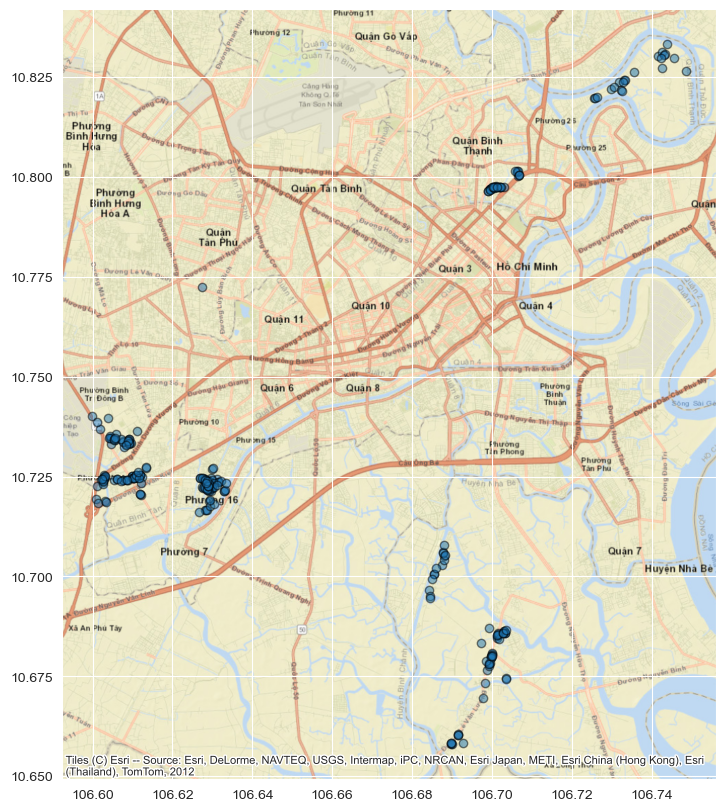

In [227]:
df_coords = df.set_crs("EPSG:4326")
#df_coords_2 = df_coords.to_crs(epsg=3857)

ax = df_coords["geometry"].plot(figsize=(10, 10), alpha=0.5, edgecolor="k") # cx default needs epsg=3857  .to_crs('EPSG:3857').
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldStreetMap)#, zoom=15) #,crs='EPSG:4326')#,  , source=cx.providers.TomTom.Basic)  .MapTiler.
                         
#mpl.display(fig=ax.figure, crs=df_coords_2.crs)


## Correlation between variables by Pearson Correlation Coefficient

Identify canidates for the predicand "direct costs for damages of buiness contents" using Pearson Correlation Coefficient

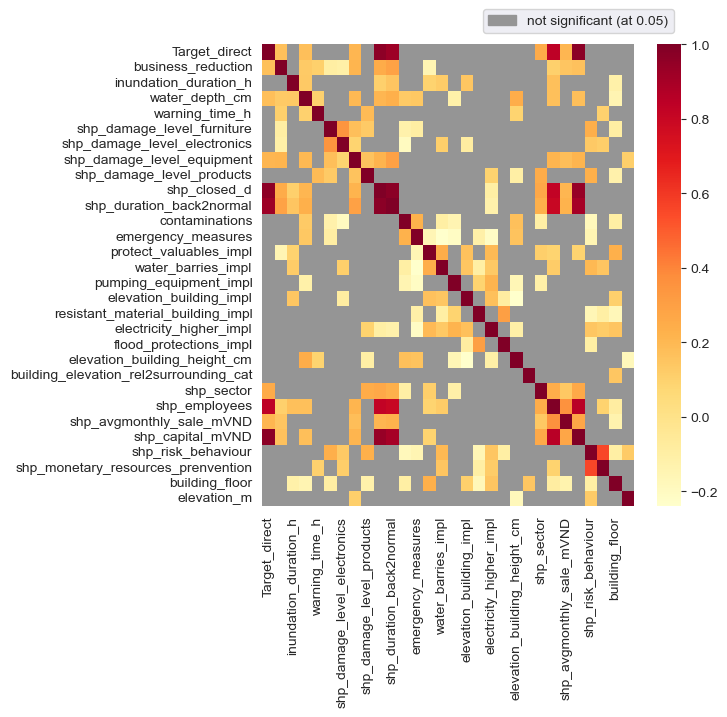

In [269]:
## Code snippet : https://stackoverflow.com/questions/69900363/colour-statistically-non-significant-values-in-seaborn-heatmap-with-a-different


df_sm = df_candidates.drop(columns=['Q0.1', 'lat', 'lon', 'geometry', 'shp_damage_level_others',
        'shp_damage_level_others_r.specify', 'shp_damage_level_others_s.specify', 'insurance_business'
        ])
# None of the businesses has a insunrance either for the building or the shop


# get the p value for pearson coefficient, subtract 1 on the diagonal
pvals =df_sm.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*df_sm.corr().shape)
psig = 0.05  # 5% signif level

plt.figure(figsize=(6,6))
#sns.heatmap(df_sm.corr()[pvals<psig], annot=False, square=False, cmap="YlOrRd", fmt=".2f", zorder=1)
sns.heatmap(df_sm.corr(), annot=False, square=False, cmap="YlOrRd", fmt=".2f", zorder=1)

# add another heatmap with colouring the non-significant cells
sns.heatmap(df_sm.corr()[pvals>=psig], annot=False, square=False, cbar=False, 
            cmap=sns.color_palette("Greys", n_colors=1, desat=1),  zorder = 2) #put the map above the heatmap
# add a label for the colour
colors = [sns.color_palette("Greys", n_colors=1, desat=1)[0]]
texts = [f"not significant (at {psig})"]
patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
plt.legend(handles=patches, bbox_to_anchor=(.85, 1.05), loc='center')

#### Summarize Pearson Corr Coefs
--> many predictors have not a signicant relationship to the target,- but this only for linear relationships
--> high corr (>0.8) between targets ~ [shp_closed_d, shp_duration_back2normal, shp_emplees, shp_capital_mVND]
--> Low corr coeffs between targets, for 
    emergency_measures, 
    private precautions in VND (eg. water-barriers, water-resistant material) - TODO check for implementations
    building_elevation_rel2surrounding
    warning_time_h
    building_floor
    shp_risk_behaviour
    shp_monetary_resources_prenvention
    --> replace them or combine them with PCA

--> TODO examine shp_damage_level_products low correlation to targets - why?

#### quantify mulitcollinearity


In [ ]:
df_vif = pd.DataFrame()
df_vif["features"] = df_candidates_X.columns
df_candidates_X_filled = df_candidates_X.replace(np.nan, 0)
df_vif["vif_scores"] = [variance_inflation_factor(df_candidates_X_filled.values.astype(float), i)  for i in range(len(df_candidates_X_filled.columns))]
df_vif.sort_values("vif_scores", ascending=False)  
# VIF >5 : high correlation
# VIF 1-10: medium correlation


,features,vif_scores
11,flood_protections_impl,143.576058
12,resistant_material_building_impl,119.823830
0,shp_closed_d,29.405256
1,shp_duration_back2normal,20.531232
9,protect_valuables_impl,17.021937
10,water_barries_impl,13.974013
21,shp_capital_mVND,11.219102
6,contaminations,8.998710
19,shp_employees,7.936704
20,shp_avgmonthly_sale_mVND,7.022346


##### Summarize VIF scores
--> Pearson Corr Coeff shows bivariate correlation between one var ~ to another var
--> VIF shows Correlation between one var ~ group of other vars

--> precaution measures and shop size  (i.e. nmbr employees,registed capital )will probably inlfucnence the model predictions of damage costs.
--> multicollineary can decrease ML learning (matters only for Regressions). For RF it limits interpretability of used features, i.e. less expressive feature importance, due to redundancy of features  (esp. if only few trees were used) 

--> apply PCA to reduce dimensionality and to solve mulitcollinearity of some predictors (esp. for shp_closed_d, shp_duration_back2normal, shp_capital_mVND, shp_employees,	business_reduction_s, contaminations, shp_avgmonthly_sale_mVND business_reduction_r) or alternatively remove redundant variables , alternativly apply feature selection by e.g. Random Forests "feature importance"


## Variable distribution
- types of businesses = DONE
- water depth and inundation duration = DONE
- educational level
- distribution and amount of obs for business disruptions [monthly reduction %] P1Q5.9
- target 1 : direct costs of losses for business contents [VND] DONE 


In [ ]:
df_candidates.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 26 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Target_direct_s                     247 non-null    Int64
 1   Target_direct_r                     246 non-null    Int64
 2   inundation_duration_h               252 non-null    Int64
 3   water_depth_cm                      252 non-null    Int64
 4   contaminations                      252 non-null    Int64
 5   warning_time_h                      252 non-null    Int64
 6   emergency_measures                  252 non-null    Int64
 7   protect_valuables_impl              252 non-null    Int64
 8   water_barries_impl                  252 non-null    Int64
 9   flood_protections_impl              252 non-null    Int64
 10  resistant_material_building_impl    252 non-null    Int64
 11  elevation_building_height_cm        252 non-null    Int64
 12  building

### Visual analysis of predictor and predicted variable distributions 

#### Summarize visual exploration of variable distribtuions
--> drop var: building_elevation2surrounding
--> mostly exponential distribution, sometimes gaussian distr.

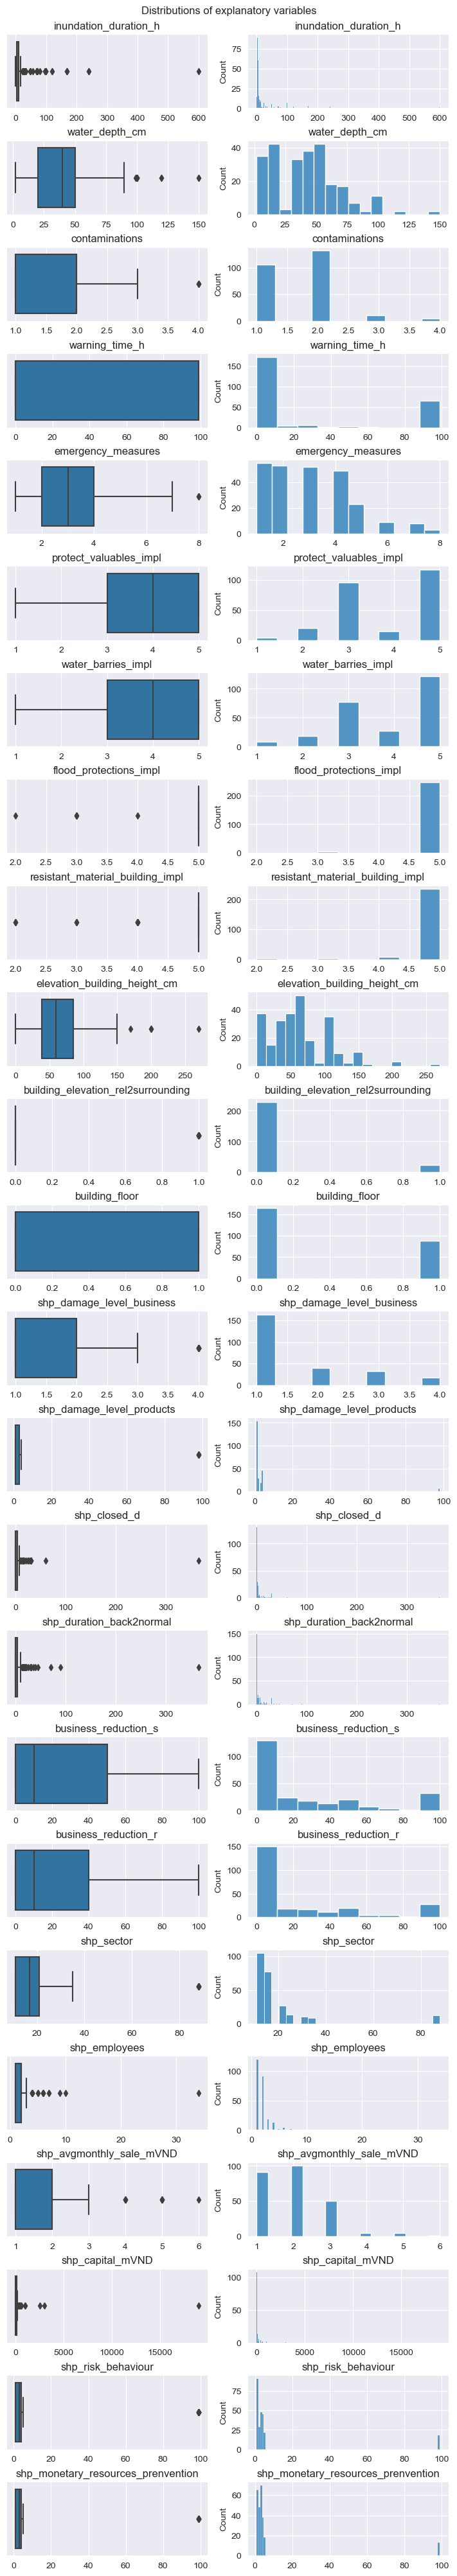

In [ ]:
#plt.figure(figsize=(58, 28))

fig, (ax_hist) = plt.subplots(len(df_candidates_X.columns), 2, sharex=False, figsize=(7, 40), constrained_layout=True)#, gridspec_kw={"height_ratios": (.15, .85)})
#fig.tight_layout()  # alternative for tight_layout() and subplots_adjust(): constrained_layout=True
fig.suptitle('Distributions of explanatory variables')

for i, c in enumerate(df_candidates_X.columns[:]):
    #plt.subplots_adjust(hspace=.2)
    sns.boxplot(x=df_candidates_X[c].astype(float), ax=ax_hist[i, 0]).set(title=f"{c}", xlabel=None)
    sns.histplot(x=df_candidates_X[c].astype(float), stat='count', ax=ax_hist[i, 1]).set(title=f"{c}", xlabel=None) # bins=12, stat="percent"


## TODO : shp_closed, shp_duration_back2normal, shp_damage_level from conitnous -> intervals

# sns.despine(ax=ax_hist)  # arrange boxplots above bar charts
# sns.despine(ax=ax_box, left=True)
# ax_box.set(yticks=[])


#### Target distributions


In [ ]:

#plt.figure(figsize=(10, 28))

fig, (ax_hist) = plt.subplots(len(df_candidates_Y.columns), 2, sharex=False, figsize=(15, 5), constrained_layout=True)#, gridspec_kw={"height_ratios": (.15, .85)})
fig.suptitle('Distributions of predicted variables')
plt.xlim(0, 15)

for i, c in enumerate(df_candidates_Y.columns[:]):
    ax_hist[i,1].set_xlim(0,22)  # limit histoplot
    sns.boxplot(x=df_candidates_Y[c].astype(float), showfliers=True, ax=ax_hist[i, 0]).set(title=f"{c}", xlabel=None)
    sns.histplot( x=df_candidates_Y[c].astype(float), stat='count', ax=ax_hist[i, 1]).set(title=f"{c} - excluded outliers", xlabel=None) #  stat='count', errorbar=("pi", 95), # stat='count', log_scale=True #.set(title=c) # bins=12, stat="percent"
    #sns.countplot(df_candidates_Y[c].astype(float).astype('Int64'), ax=ax_hist[i, 1])  # discrete=False,



NameError: name 'df_candidates_Y' is not defined

#### business types 
grouped by their parent sector


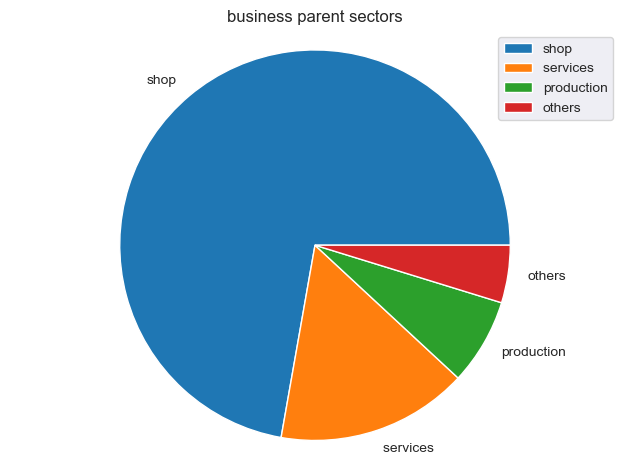

In [ ]:
bins =  np.arange(10, 90, 10)  # business sectors
ind = np.digitize(df['shp_sector'], bins)
 
shp_sectors = df.shp_sector.groupby(ind).value_counts().reset_index(name='sector_freq')
shp_sectors = shp_sectors.groupby("level_0")['sector_freq'].sum().reset_index()
#shp_sectors.shp_sector = shp_sectors.shp_sector.replace([11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 31, 32, 33, 34, 35, 88],["food","fashion", "houseware"])

shp_sectors["sectors"] = shp_sectors.level_0.replace([1, 2, 3, 8],["shop", "services ", "production", "others"])

plt.pie(x="sector_freq", labels="sectors", data=shp_sectors)
plt.legend(shp_sectors.sectors, loc="best")
plt.title("business parent sectors")
plt.axis('equal')
plt.tight_layout()
plt.show()

##### business types of shops

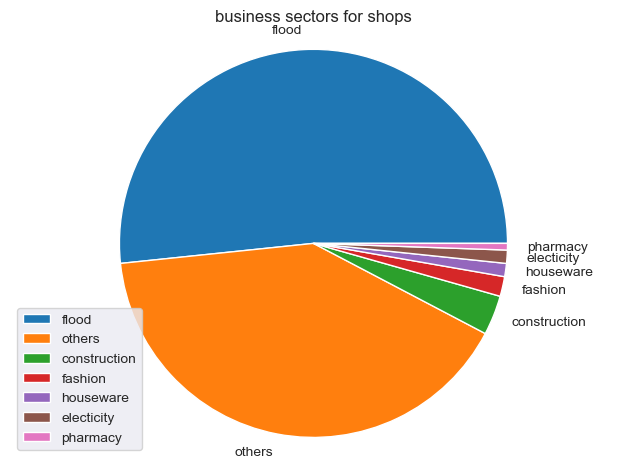

In [ ]:
shop_types = df.shp_sector[df['shp_sector'] < 20]
#shop_types = df[(df['shp_sector'] >= 10) & (df['shp_sector'] < 20)]
shop_types = shop_types.value_counts().reset_index(name='shop_freq')
shop_types["shop_type"] = shop_types.shp_sector.replace([11, 12, 13, 14, 15, 16, 17],["food", "fashion", "houseware", "construction", "electicity", "pharmacy", "others"])

plt.pie(x="shop_freq", labels="shop_type", data=shop_types)
plt.legend(shop_types.shop_type, loc="best")
plt.title("business sectors for shops")
plt.axis('equal')
plt.tight_layout()
plt.show()


### Statistics of variable distributions
mean, SD, amount of NAN

In [208]:
df_stats =pd.DataFrame(index=df_candidates.columns)

for c in df_candidates.columns.drop(["lat", "lon", "geometry"]):
    df_stats.loc[c, "min"] = df_candidates[c].min()
    df_stats.loc[c, "max"] = df_candidates[c].max()
    df_stats.loc[c, "mean"] = df_candidates[c].mean()#.round(2)
    df_stats.loc[c, "median"] = df_candidates[c].median()
    df_stats.loc[c, "sd"] = df_candidates[c].std()#.round(2)
    df_stats.loc[c, "no_value"] = df_candidates[c].isin([0, 99]).sum() | df_candidates[c].isna().sum()

print(df_stats.head(10))    


                           min     max       mean  median          sd   
Target_direct              0.0  6000.0  33.884524     0.0  381.069413  \
business_reduction         0.0   100.0  25.803181    10.0   32.887939   
inundation_duration_h      0.0   600.0  14.146230     3.0   48.022307   
water_depth_cm             1.0   150.0  34.950397    30.0   26.028573   
warning_time_h             0.0    60.0   1.582341     0.0    6.943801   
shp_damage_level_business  1.0     4.0   1.519841     1.0    0.887064   
shp_damage_level_products  1.0    98.0   4.200397     1.0   15.318537   
shp_closed_d               0.0   365.0   4.216270     0.0   23.781202   
shp_duration_back2normal   0.0   365.0   5.769841     0.0   24.941096   
contaminations             1.0     4.0   1.684524     2.0    0.653541   

                           no_value  
Target_direct                 293.0  
business_reduction            223.0  
inundation_duration_h          10.0  
water_depth_cm                  1.0  
warnin

c:\Anaconda\envs\py396_c3\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


#### Summarize quantitative exploration of variable distribtuions
--> warning_time_h and elevation rel2surounding have more than 200 entires missing (total 252 obs), therefore these variabels should be combined with other variables to a new variable (PCA) or should be excluded from feature space